In [ ]:
pip install -q tfds-nightly

     |████████████████████████████████| 3.6MB 2.8MB/s 


In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [ ]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteF6X21Q/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteF6X21Q/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteF6X21Q/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [ ]:
encoder = info.features['text'].encoder

In [ ]:
encoder

<SubwordTextEncoder vocab_size=8185>

In [ ]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [ ]:
sample_string = 'Hello BEPEC Learners.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 2748, 4460, 1831, 2414, 1066, 690, 7975]
The original string: "Hello BEPEC Learners."


In [ ]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
2748 ----> BE
4460 ----> PE
1831 ----> C 
2414 ----> Lea
1066 ----> rn
690 ----> ers
7975 ----> .


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


In [ ]:
history = model.fit(train_dataset, epochs=2,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/2
391/391 [==============================] - 878s 2s/step - loss: 0.5437 - accuracy: 0.6753 - val_loss: 0.3952 - val_accuracy: 0.8016
Epoch 2/2
391/391 [==============================] - 891s 2s/step - loss: 0.2944 - accuracy: 0.8792 - val_loss: 0.3271 - val_accuracy: 0.8646


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 177s 452ms/step - loss: 0.3240 - accuracy: 0.8657
Test Loss: 0.32397690415382385
Test Accuracy: 0.8656799793243408


In [21]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [22]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [23]:
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[0.43116078]]


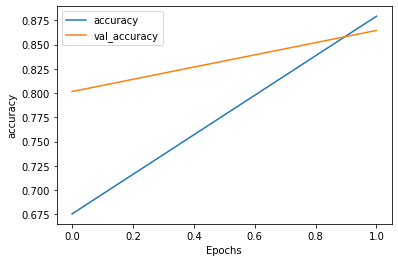

In [24]:
plot_graphs(history, 'accuracy')